In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import pickle

In [42]:
from experiments import EGUOptimalSetup
from experiments import utilities as utils
from bayesinverse import Regression

In [43]:
config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/egu_optimal_setup/config.yaml"
)

exp = EGUOptimalSetup(config_path)
# basic_setup.run()


sensors 0.00293789803981781
emissions 2.869273766875267
transport 24.957476556301117


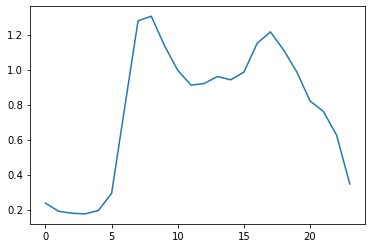

In [44]:
plt.plot(utils.stack_xr(exp.emissions.truth.mean("source_group")))

In [45]:
source_group_path = Path(
    "/mnt/data/users/rmaiwald/GRAMM-GRAL/emissions/pickle_jar/source_groups_infos.csv"
)
source_group_df = pd.read_csv(
    source_group_path,
    index_col=0,
)


In [46]:
path = Path("/mnt/data/users/rmaiwald/")

with open(
    path / "GRAMM-GRAL/emissions/heat_traffic/tno_districts_gdf.pickle",
    "rb",
) as file:
    tno_districts_gdf = pickle.load(file)


In [47]:
abs_emissions = exp.emissions.absolute_emissions

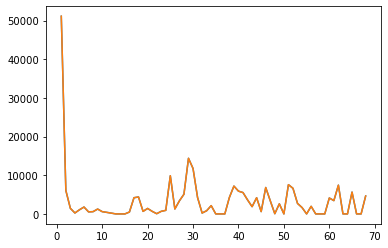

In [48]:
plt.plot(np.arange(len(abs_emissions)) + 1, abs_emissions)
plt.plot(source_group_df["CO2[kg/hour]"])

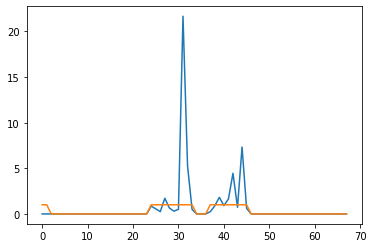

In [49]:
plt.plot(exp.emissions.get_mean_TNO())
plt.plot(exp.emissions.get_TNO())

In [50]:
[(source_group_df["source_type"] == "TNO area").values]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])]

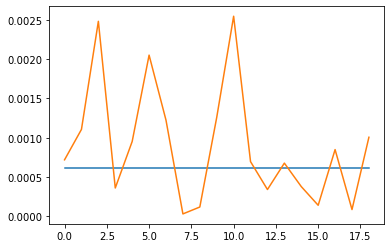

In [51]:
plt.plot(
    (exp.emissions.get_mean_TNO() * exp.emissions.absolute_emissions)[
        (source_group_df["source_type"] == "TNO area").values
    ]
    / tno_districts_gdf["area"]
)
plt.plot(
    (exp.emissions.get_TNO() * exp.emissions.absolute_emissions)[
        (source_group_df["source_type"] == "TNO area").values
    ]
    / tno_districts_gdf["area"]
)


In [67]:
# Sanity check
print((exp.emissions.get_mean_TNO_with_points() * exp.emissions.absolute_emissions).sum())
print((exp.emissions.get_TNO() * exp.emissions.absolute_emissions).sum())

<xarray.DataArray ()>
array(150418.76026199)
<xarray.DataArray ()>
array(150418.76026199)


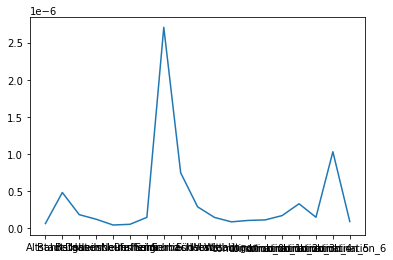

In [53]:
plt.plot(
    exp.emissions.get_mean_TNO()[source_group_df["source_type"] == "TNO area"]
    / tno_districts_gdf["area"] 
)


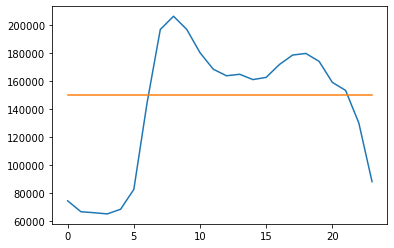

In [54]:
plt.plot(exp.emissions.truth_absolute.sum("source_group"))
plt.plot(exp.emissions.prior_absolute.sum("source_group"))
pass

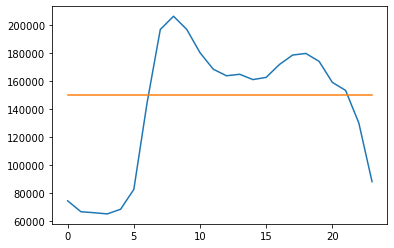

In [ ]:
plt.plot(exp.emissions.truth_absolute.sum("source_group"))
plt.plot(exp.emissions.prior_absolute.sum("source_group"))
pass

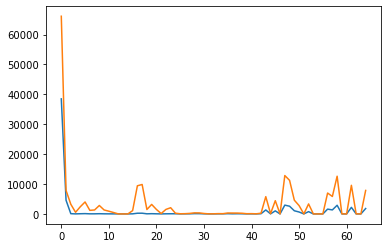

In [55]:
plt.plot(exp.emissions.truth_absolute.min("time_state"))
plt.plot(exp.emissions.truth_absolute.max("time_state"))


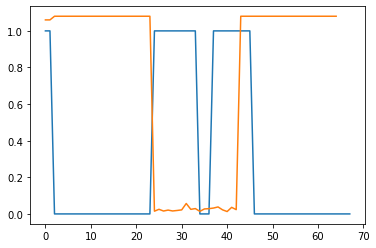

In [56]:
plt.plot(exp.emissions.get_TNO())
plt.plot(exp.emissions.truth.mean("time_state"))


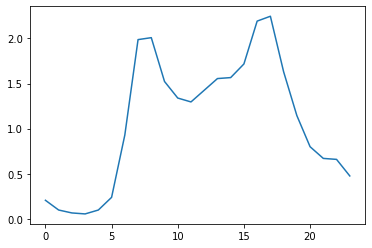

In [57]:
plt.plot(exp.emissions.truth.isel(source_group=10))

In [58]:
n_processes = 32
exp.K = exp.transport.get_transport(
    exp.sensors.n_sensors, exp.sensors.get_index(), exp.emissions, n_processes
)


loop start 19.248036727309227
loop end 19.321535736322403


In [59]:
exp.reg = Regression(
    y=utils.stack_xr(
        exp.K @ exp.emissions.truth
        + exp.sensors.get_noise()
    ).values,
    K=utils.stack_xr(exp.K).values,
    x_prior=utils.stack_xr(exp.emissions.prior).values,
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
    y_covariance=utils.stack_xr(
        exp.sensors.get_covariance()
    ).values,
)
x_est, res, rank, s = exp.reg.fit()


In [76]:
posterior = exp.emissions.to_xr(x_est)


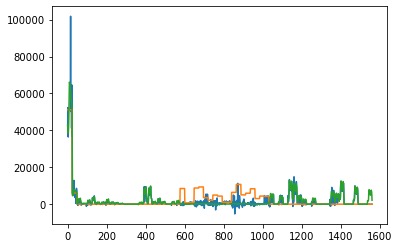

In [77]:
plt.plot(utils.stack_xr(utils.unstack_xr(posterior) * exp.emissions.absolute_emissions))
plt.plot(utils.stack_xr(exp.emissions.prior_absolute))
plt.plot(utils.stack_xr(exp.emissions.truth_absolute))

In [78]:
posterior_covariance = exp.emissions.to_xr(exp.reg.get_posterior_covariance())

In [79]:
error_reduction = exp.emissions.to_xr(exp.reg.get_error_reduction())

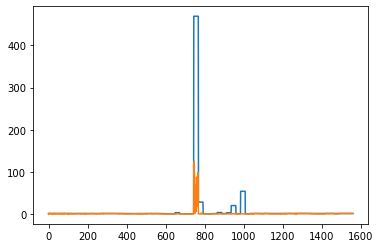

In [80]:
plt.plot(utils.stack_xr(exp.emissions.prior_covariance))
plt.plot(np.diag(posterior_covariance))

Mean error reduction: <xarray.DataArray ()>
array(52.41083466)


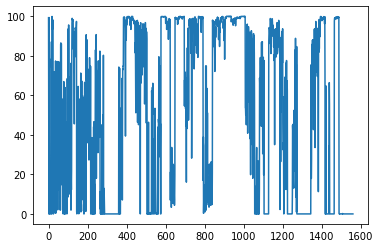

In [81]:
plt.plot(error_reduction)
print(f"Mean error reduction: {error_reduction.mean()}")

In [82]:
posterior = utils.unstack_xr(posterior) * exp.emissions.absolute_emissions

In [93]:
rmse = utils.compute_rmse(
    posterior.sum("source_group"), exp.emissions.truth_absolute.sum("source_group")
).values
print(f"RMSE: {int(rmse)} kg/h")
mean_total_emissions = exp.emissions.truth_absolute.sum("source_group").mean().values
print(f"of mean total emissions {int(mean_total_emissions)} kg/h")
mean_total_posterior = posterior.sum("source_group").mean().values
print(f"of mean total posterior {int(mean_total_posterior)} kg/h")
print(f"which equals a rmse of {int(rmse/mean_total_emissions*100)}%")
mean_total_prior = exp.emissions.prior_absolute.sum("source_group").mean().values
print(f"from an prior of {int(mean_total_prior)} kg/h")
rmse_prior = utils.compute_rmse(
    exp.emissions.prior_absolute.sum("source_group"), exp.emissions.truth_absolute.sum("source_group")
).values
print(f"with an rmse of {int(rmse_prior)} kg/h")



RMSE: 21430 kg/h
of mean total emissions 141985 kg/h
of mean total posterior 131469 kg/h
which equals a rmse of 15%
from an prior of 150418 kg/h
with an rmse of 47883 kg/h


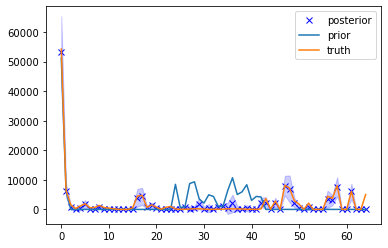

In [72]:
mean = posterior.mean("time_state")
std = posterior.std("time_state")
line = plt.plot(mean, "bx", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

plt.plot(exp.emissions.prior_absolute.mean("time_state"), label="prior")
plt.plot(exp.emissions.truth_absolute.mean("time_state"), label="truth")
plt.legend()

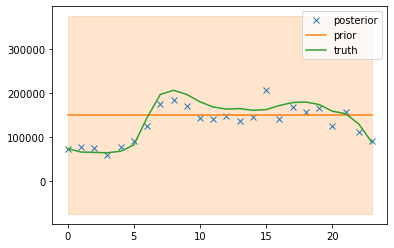

In [75]:
mean = posterior.sum("source_group")
# std = np.tile(posterior.mean("source_group").std("time_state"), len(mean))
# std = np.sqrt(utils.var_of_sum(posterior_covariance))
line = plt.plot(mean, "x", label="posterior")[0]
# plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean = exp.emissions.prior_absolute.sum("source_group")
std = np.sqrt(
    exp.emissions.prior_variance
    * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
).sum("source_group")
line = plt.plot(mean, label="prior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

plt.plot(exp.emissions.truth_absolute.sum("source_group"), label="truth")
plt.legend()


0.9392771851641731
0.4156784805055098
0.8411155458255388
1.2019297591900346
1.0353867820957041
0.9459619357072531
0.9966356116449577
0.9948094664377324
0.9568163901281711
2.3754020574327868
1.125309450134475
1.5674328326888736
0.09622908512444636
0.9549995091715493
1.014421956939244
0.992628115058451
0.9945536223908064
0.8888676572614314
1.0420431950653855
1.661835895459299
0.20342964770303312


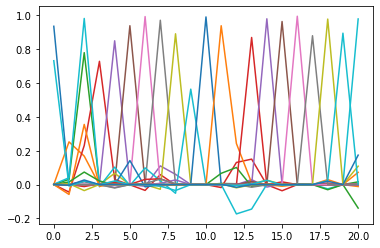

In [ ]:
averaging_kernel = exp.reg.get_averaging_kernel()
for i in range(averaging_kernel.shape[0]):
    kernel = averaging_kernel[i]
    plt.plot(kernel, label=kernel.sum())
    print(kernel.sum())
# plt.legend()


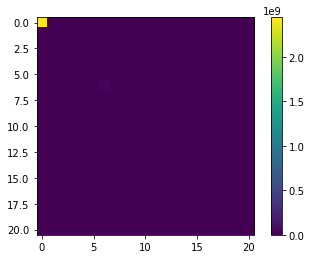

In [ ]:
im = plt.imshow(
    exp.emissions.truth_absolute.values
    * exp.reg.get_averaging_kernel()
    * exp.emissions.truth_absolute.values.T
)
plt.colorbar(im)


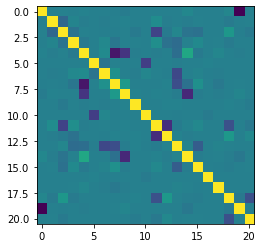

In [ ]:
plt.imshow(exp.reg.get_correlation())

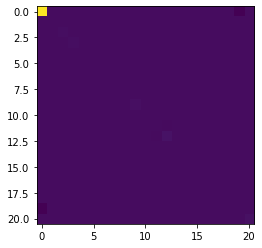

In [ ]:
plt.imshow(
    exp.emissions.truth_absolute.values
    * exp.reg.get_posterior_covariance()
    * exp.emissions.truth_absolute.values.T
)


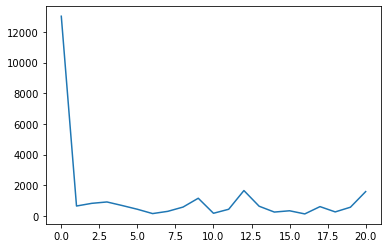

In [ ]:
plt.plot(
    np.sqrt(np.diag(exp.reg.get_posterior_covariance()))
    * exp.emissions.truth_absolute.values[:, 0]
)


In [ ]:
exp.reg.get_information_content(), exp.reg.get_dof_signal(), exp.reg.get_dof_noise()

(28.371533660094514, 16.663266611992587, 4.3367333880074135)